In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
#from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import ResNet101
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

Using TensorFlow backend.


In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 255
test_images = test_images.astype('uint16') / 255

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_resnet101(verbose=False, fc_size=256, dropout=None):
    
    resnet101_base = ResNet101(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet101 = models.Sequential()
    resnet101.add(resnet101_base)

    resnet101.add(layers.Flatten())
    if dropout is not None:
        resnet101.add(layers.Dropout(dropout))
    resnet101.add(layers.Dense(fc_size, activation='relu'))
    resnet101.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    resnet101_base.trainable = False
    
    if verbose:
        resnet101_base.summary()
        resnet101.summary()

    return resnet101

In [22]:
resnet101_fe_drop_temp = create_resnet101(verbose=True, dropout=0.5, fc_size=256)

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [6]:
# Instantiate a VGG19 network with custom final layer
resnet101_fe_drop_128 = create_resnet101(dropout=0.5, fc_size=128)

In [7]:
resnet101_fe_drop_128.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 8, 8, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 59,436,036
Trainable params: 16,777,860
Non-trainable params: 42,658,176
_________________________________________________________________


In [8]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('resnet101_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
resnet101_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train
history_resnet101_fe_drop_128 = resnet101_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 12.4455 - accuracy: 0.2651
Epoch 00001: val_loss improved from inf to 1.38822, saving model to resnet101_fe_drop_128_4cl_best.h5
19/19 [==============================] - 35s 2s/step - loss: 11.7275 - accuracy: 0.2638 - val_loss: 1.3882 - val_accuracy: 0.2285
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.4091 - accuracy: 0.3309
Epoch 00002: val_loss improved from 1.38822 to 1.38194, saving model to resnet101_fe_drop_128_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.4082 - accuracy: 0.3290 - val_loss: 1.3819 - val_accuracy: 0.3677
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.4156 - accuracy: 0.3409
Epoch 00003: val_loss did not improve from 1.38194
19/19 [======================

18/19 [===========================>..] - ETA: 1s - loss: 1.2665 - accuracy: 0.4190
Epoch 00026: val_loss did not improve from 1.33039
19/19 [==============================] - 29s 2s/step - loss: 1.2624 - accuracy: 0.4200 - val_loss: 1.3434 - val_accuracy: 0.3213
Epoch 27/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2730 - accuracy: 0.4258
Epoch 00027: val_loss did not improve from 1.33039
19/19 [==============================] - 29s 2s/step - loss: 1.2750 - accuracy: 0.4264 - val_loss: 1.3528 - val_accuracy: 0.3230
Epoch 28/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2756 - accuracy: 0.4199
Epoch 00028: val_loss did not improve from 1.33039
19/19 [==============================] - 29s 2s/step - loss: 1.2760 - accuracy: 0.4153 - val_loss: 1.3488 - val_accuracy: 0.3230
Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2644 - accuracy: 0.4344
Epoch 00029: val_loss did not improve from 1.33039
19/19 [==============================]

In [11]:
# Save
models.save_model(resnet101_fe_drop_128, 'resnet101_fe_drop_128_4cl_end.h5')

In [12]:
# History of accuracy and loss
tra_loss_fe = history_resnet101_fe_drop_128.history['loss']
tra_acc_fe = history_resnet101_fe_drop_128.history['accuracy']
val_loss_fe = history_resnet101_fe_drop_128.history['val_loss']
val_acc_fe = history_resnet101_fe_drop_128.history['val_accuracy']

In [13]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_fe_drop_128 = models.load_model('resnet101_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet101_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [14]:
print("resnet101 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 54
Epoch [opt]: 24
Valid accuracy [end]: 0.3436
Valid accuracy [opt]: 0.3471
Test accuracy [end]:  0.3939
Test accuracy [opt]:  0.3237
Valid loss [end]: 1.5888
Valid loss [opt]: 1.3304
Test loss [end]:  1.3898
Test loss [opt]:  1.3104


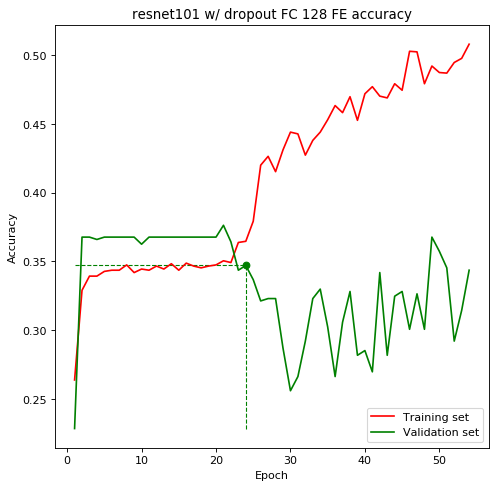

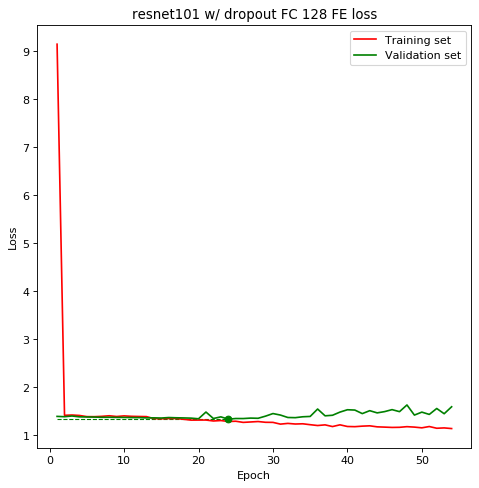

In [15]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [16]:
# Instantiate a VGG19 network with custom final layer
resnet101_fe_drop_256 = create_resnet101(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('resnet101_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
resnet101_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train
history_resnet101_fe_drop_256 = resnet101_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 44.5793 - accuracy: 0.2951
Epoch 00001: val_loss improved from inf to 1.40715, saving model to resnet101_fe_drop_256_4cl_best.h5
19/19 [==============================] - 34s 2s/step - loss: 41.9427 - accuracy: 0.2960 - val_loss: 1.4071 - val_accuracy: 0.3196
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.4151 - accuracy: 0.3305
Epoch 00002: val_loss improved from 1.40715 to 1.36864, saving model to resnet101_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.4158 - accuracy: 0.3320 - val_loss: 1.3686 - val_accuracy: 0.3797
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3914 - accuracy: 0.3234
Epoch 00003: val_loss did not improve from 1.36864
19/19 [==============================] - 29s 2s/step - loss: 1.3919 - accuracy: 0.3239 - val_loss: 1.3712

Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2002 - accuracy: 0.4589
Epoch 00029: val_loss did not improve from 1.33558
19/19 [==============================] - 29s 2s/step - loss: 1.1992 - accuracy: 0.4603 - val_loss: 1.7938 - val_accuracy: 0.3076
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1800 - accuracy: 0.4830
Epoch 00030: val_loss did not improve from 1.33558
19/19 [==============================] - 29s 2s/step - loss: 1.1782 - accuracy: 0.4818 - val_loss: 1.8029 - val_accuracy: 0.2698
Epoch 31/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1685 - accuracy: 0.4857
Epoch 00031: val_loss did not improve from 1.33558
19/19 [==============================] - 29s 2s/step - loss: 1.1684 - accuracy: 0.4822 - val_loss: 1.7584 - val_accuracy: 0.2852
Epoch 32/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1586 - accuracy: 0.4907
Epoch 00032: val_loss did not improve from 1.33558
19/19 [==================

In [18]:
# Save
models.save_model(resnet101_fe_drop_256, 'resnet101_fe_drop_256_4cl_end.h5')

In [19]:
# History of accuracy and loss
tra_loss_fe = history_resnet101_fe_drop_256.history['loss']
tra_acc_fe = history_resnet101_fe_drop_256.history['accuracy']
val_loss_fe = history_resnet101_fe_drop_256.history['val_loss']
val_acc_fe = history_resnet101_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_fe_drop_256 = models.load_model('resnet101_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet101_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("Resnet101 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

Resnet101 (w/ dropout) Feature Extraction

Epoch [end]: 37
Epoch [opt]: 7
Valid accuracy [end]: 0.2680
Valid accuracy [opt]: 0.3058
Test accuracy [end]:  0.3573
Test accuracy [opt]:  0.3496
Valid loss [end]: 1.6671
Valid loss [opt]: 1.3356
Test loss [end]:  1.5248
Test loss [opt]:  1.3259


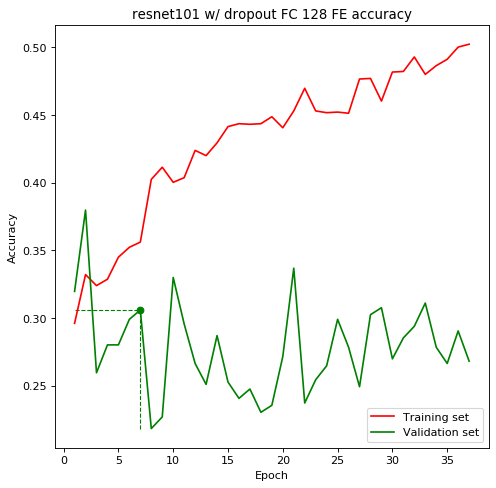

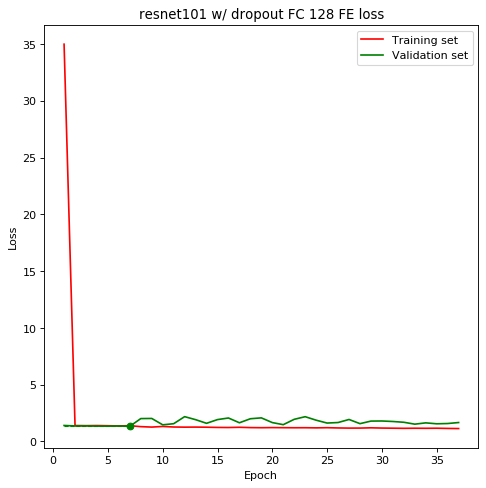

In [20]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [21]:
models.load_model('resnet101_fe_drop_128_4cl_best.h5').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 8, 8, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 59,436,036
Trainable params: 16,777,860
Non-trainable params: 42,658,176
_________________________________________________________________


In [25]:
resnet101_ft_1layer = models.load_model('resnet101_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in resnet101_ft_1layer.get_layer('resnet101').layers:
    if layer.name.startswith('conv5_block3_3_bn'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet101_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

resnet101_ft_1layer.summary()
resnet101_ft_1layer.get_layer('resnet101').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 8, 8, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 59,436,036
Trainable params: 16,781,956
Non-trainable params: 42,654,080
_________________________________________________________________
Model: "resnet101"
__________________________________________________________________________________

In [26]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'resnet101_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [27]:
# Train
history_ft = resnet101_ft_1layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2631 - accuracy: 0.3659
Epoch 00001: val_loss improved from inf to 1.37644, saving model to resnet101_ft_1layer_4cl_best.h5
19/19 [==============================] - 34s 2s/step - loss: 1.2635 - accuracy: 0.3647 - val_loss: 1.3764 - val_accuracy: 0.3351
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2632 - accuracy: 0.3650
Epoch 00002: val_loss improved from 1.37644 to 1.35591, saving model to resnet101_ft_1layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.2643 - accuracy: 0.3664 - val_loss: 1.3559 - val_accuracy: 0.3007
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2532 - accuracy: 0.3845
Epoch 00003: val_loss did not improve from 1.35591
19/19 [==============================] - 29s 2s/step - loss: 1.2559 - accuracy: 0.3874 - val_loss: 1.3651 - val

18/19 [===========================>..] - ETA: 1s - loss: 1.2256 - accuracy: 0.4535
Epoch 00029: val_loss did not improve from 1.34046
19/19 [==============================] - 29s 2s/step - loss: 1.2236 - accuracy: 0.4590 - val_loss: 1.3788 - val_accuracy: 0.3007
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2263 - accuracy: 0.4453
Epoch 00030: val_loss did not improve from 1.34046
19/19 [==============================] - 29s 2s/step - loss: 1.2270 - accuracy: 0.4492 - val_loss: 1.3774 - val_accuracy: 0.3368
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2266 - accuracy: 0.4444
Epoch 00031: val_loss did not improve from 1.34046
19/19 [==============================] - 29s 2s/step - loss: 1.2313 - accuracy: 0.4414 - val_loss: 1.4181 - val_accuracy: 0.2869
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2215 - accuracy: 0.4553
Epoch 00032: val_loss did not improve from 1.34046
19/19 [==============================]

In [28]:
# Save
models.save_model(resnet101_ft_1layer, 'resnet101_ft_1layer_4cl_end.h5')

In [29]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_ft_1layer = models.load_model('resnet101_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet101_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("resnet101 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 Fine Tuning

Epoch [end]: 36
Epoch [opt]: 6
Valid accuracy [end]: 0.3007
Valid accuracy [opt]: 0.3351
Test accuracy [end]:  0.3786
Test accuracy [opt]:  0.3664
Valid loss [end]: 1.4122
Valid loss [opt]: 1.3405
Test loss [end]:  1.2869
Test loss [opt]:  1.3069


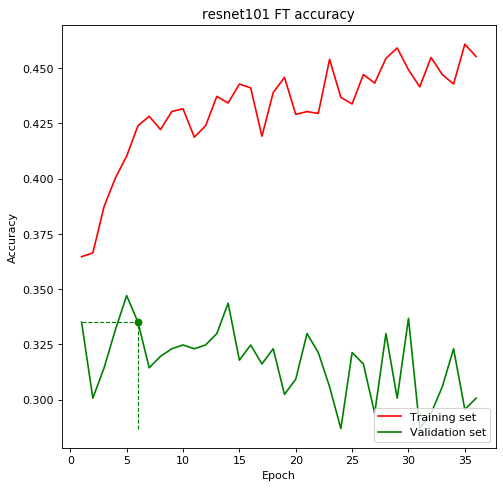

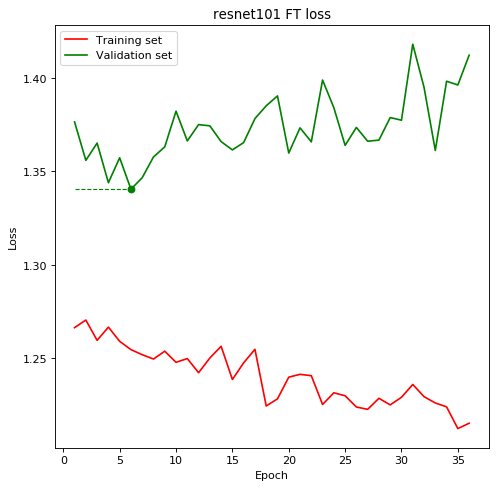

In [30]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();